<a href="https://colab.research.google.com/github/iruamfx/DataAnalysis/blob/main/Sistema_de_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistema de Recomendacao**

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df_movies = pd.read_csv('/content/drive/MyDrive/xpe/movies.csv')
df_ratings = pd.read_csv('/content/drive/MyDrive/xpe/ratings.csv')

In [3]:
df_ratings.head() #timestamp: segundos desde a data unix (01/01/1970)
                  #userId: vai até 610, contando com diversas avaliações

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#Resgatar filme com id 50 do dataset
print(df_movies[df_movies['movieId'] == 50])

    movieId                       title                  genres
46       50  Usual Suspects, The (1995)  Crime|Mystery|Thriller


In [6]:
# Agrupa dataframes de filmes e avaliacao baseado no movieId
movie_rating = pd.merge(df_movies, df_ratings, on='movieId')

# Processamento dos Dados

In [7]:
import matplotlib.pyplot as plt #Graficos estilo MatLab
import seaborn as sns #Graficos mais avancados

In [8]:
# Obter media das avaliacoes por cada filme - individualmente.
movie_rating.groupby("title")["rating"].mean().sort_values(ascending=False).head()
# Particulariza por titulo e retorna instancia de df modificado,
# Obtem atributo rating deste df retornado,
# Tira a media do atributo em todas as entidades,
# Coloca instancia de df em ordem decrescente e mostra o head

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0


In [9]:
# Obtem qntd de avaliacoes por cada filme - individualmente.
movie_rating.groupby("title")["rating"].count().sort_values(ascending=False).head()

,rating
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278


**Criacao do dataframe Ratings**

In [10]:
#Cria dataframe baseado no movie_rating, individualizado por title, e contendo media das ratings
ratings = pd.DataFrame(movie_rating.groupby("title")["rating"].mean())
ratings.sort_values("rating", ascending=False).head()

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0


In [11]:
#Insere coluna rating_count, contendo a quantidade de avaliacoes dadas ao filme
ratings["rating_count"] = movie_rating.groupby("title")["rating"].count()
ratings.sort_values("rating_count", ascending=False).head()

,rating,rating_count
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


In [12]:
#Insere coluna rating_count_avg, contendo a media bayesiana entre a avaliacao geral, e a quantidade
#de avaliacoes dadas, para aumentar a confiabilidade.
min_trust = 50

ratings["rating_count_idx"] = (
    (movie_rating.groupby("title")["rating"].count() / (movie_rating.groupby("title")["rating"].count() + min_trust))
    * movie_rating.groupby("title")["rating"].mean()) + (
    (min_trust / (movie_rating.groupby("title")["rating"].count() + min_trust))
    * ratings["rating"].mean())
# a primeira parte da equacao: (v/v+m) * r, a qual da enfase para avaliacao geral especifica do filme,
# tende a ter mais influencia no resultado a medida que o numero de avaliacoes aumenta,
# e a segunda parte da equacao: (m/v+m) * C, a qual da enfase para a media de todas as avaliacoes gerais no df,
# tende a ter mais influencia no resultado a medida que o numero de avaliacoes diminui
ratings.sort_values("rating_count", ascending=True).head()

,rating,rating_count,rating_count_idx
title,,,
'71 (2014),4.0,1,3.276851
Latter Days (2003),3.5,1,3.267047
"Late Shift, The (1996)",2.5,1,3.247440
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog (2004),2.0,1,3.237636
Late Night Shopping (2001),4.5,1,3.286655


**Construcao da matriz de correlacao de Pearson**

In [13]:
# Agrupa a matriz por usuário, individualmente, onde cada coluna representa um filme e a respectiva avaliacao dada por um usuario especifico
usr_movie_rating = movie_rating.pivot_table(index="userId", columns="title", values="rating")
# E.x: Usuario 610 deu avaliacao 4.0 para filme '71, nenhuma para o Hellboy, e 3.5 para 500 Days of Summer
usr_movie_rating.tail()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,...,NaN,4.0,3.5,3.0,NaN,NaN,2.0,1.5,NaN,NaN


In [14]:
#Formato da matriz: 610 filmes e 9719 filmes distintos
usr_movie_rating.shape

(610, 9719)

In [15]:
# Calcula o coeficiente de correlacao linear de Pearson entre os filmes, ou seja, quao proximo os filmes estao um dos outros
#movie_corr_matrix = usr_movie_rating.corr() # ! Intenso em Processamento !

In [16]:
# Refina matriz de correlacao, realizando correlacoes somente em filmes com mais de 50 avaliacoes
movie_corr_matrix = usr_movie_rating.corr(method="pearson", min_periods=50) # ! Intenso em Processamento !

In [17]:
# Visualizacao Separada devido aos requisitos de processamento
movie_corr_matrix.tail()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
¡Three Amigos! (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
À nous la liberté (Freedom for Us) (1931),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Correlacionamento dos filmes avaliados por um usuario com outros ainda nao assistidos

**Preparo**

In [18]:
# Obtem um usuario do df de usuarios e avaliacoes por meio de iloc(), e exclui todas
# as colunas vazias (sem avaliacao) por meio de dropna()
usr_id = 600

testUser = usr_movie_rating.iloc[usr_id].dropna()
testUser.head(10).sort_values(ascending=False)

,601
title,
12 Angry Men (1957),5.0
Band of Brothers (2001),5.0
"Avengers, The (2012)",4.5
Batman Begins (2005),4.5
Big Hero 6 (2014),4.5
2012 (2009),4.0
Armageddon (1998),4.0
Avatar (2009),4.0
"Beautiful Mind, A (2001)",4.0


In [19]:
print(
"Total de avaliacoes:", len(testUser), "\n", #Total de avaliacoes dadas pelo usuario
"Nome do filme:", testUser.index[2], "\n", #Nome do terceiro filme avaliado pelo usuario
"Nota ao filme:", testUser.iloc[2], "\n") #Nota dada ao terceiro filme pelo usuario

Total de avaliacoes: 101 
 Nome do filme: Armageddon (1998) 
 Nota ao filme: 4.0 



**Correlacao**

In [20]:
# Similaridade dos filmes com Armaggedon
#movie_corr_matrix.iloc[indice].sort_values(ascending=False).head()
movie_corr_matrix[testUser.index[2]].dropna().sort_values(ascending=False)

,Armageddon (1998)
title,
Armageddon (1998),1.000000
Independence Day (a.k.a. ID4) (1996),0.665768
True Lies (1994),0.547632
Star Wars: Episode I - The Phantom Menace (1999),0.457663
American Pie (1999),0.430223
Men in Black (a.k.a. MIB) (1997),0.424516
Indiana Jones and the Temple of Doom (1984),0.420462
Braveheart (1995),0.414973
Saving Private Ryan (1998),0.409837


In [26]:
# Criacao da tabela (1D) de similaridade
similar_movies_candidates = pd.Series()
for i in range(0, len(testUser.index)): # testUser.index sao as fileiras, ou, nomes dos filmes avaliados pelo usuario
  print("Adicionando filmes similares a", testUser.index[i], "...")
  similarToI = movie_corr_matrix[testUser.index[i]].dropna() # Representa os filmes que possuem similaridade com o filme da iteracao. Busca pelo titulo (string)
  similarToI = similarToI.map(lambda x: x * testUser.iloc[i]) #Escala a similaridade para 5; onde x representa a similaridade de um filme similar, e testUser[i] representa a nota dada ao filme da iteracao pelo usuario
  if similar_movies_candidates.empty:
    similar_movies_candidates = similarToI
  else:
    similar_movies_candidates = pd.concat([similar_movies_candidates, similarToI])

Adicionando filmes similares a 12 Angry Men (1957) ...
Adicionando filmes similares a 2012 (2009) ...
Adicionando filmes similares a Armageddon (1998) ...
Adicionando filmes similares a Avatar (2009) ...
Adicionando filmes similares a Avengers, The (2012) ...
Adicionando filmes similares a Band of Brothers (2001) ...
Adicionando filmes similares a Batman Begins (2005) ...
Adicionando filmes similares a Beautiful Mind, A (2001) ...
Adicionando filmes similares a Big Hero 6 (2014) ...
Adicionando filmes similares a Blade Runner 2049 (2017) ...
Adicionando filmes similares a Bourne Ultimatum, The (2007) ...
Adicionando filmes similares a Brave (2012) ...
Adicionando filmes similares a Bug's Life, A (1998) ...
Adicionando filmes similares a Casablanca (1942) ...
Adicionando filmes similares a Casino Royale (2006) ...
Adicionando filmes similares a Catch Me If You Can (2002) ...
Adicionando filmes similares a City of God (Cidade de Deus) (2002) ...
Adicionando filmes similares a Coco (2017)

In [29]:
# Ordena a Series por similaridade dos filmes
# por exemplo: 12 Angry Men fica no topo da lista, pois o usuario deu a avaliacao 5, e sua correlacao consigo mesmo e igual a 1, ou seja,
# sua similaridade escalada sera igual a 1.0 * 5.0 = 5
similar_movies_candidates.sort_values(inplace=True, ascending=False)
similar_movies_candidates.head(15)

,0
title,
12 Angry Men (1957),5.0
"Monsters, Inc. (2001)",5.0
Life Is Beautiful (La Vita è bella) (1997),5.0
Iron Man (2008),5.0
Interstellar (2014),5.0
"Incredibles, The (2004)",5.0
Inception (2010),5.0
Fight Club (1999),5.0
"Godfather, The (1972)",5.0


In [30]:
# Os filmes similares podem ter correlacao com mais de um dos filmes avaliados, logo, para unificar a semelhanca de um filme com correlacao
# repetida, somamos a semelhanca deste filme em todas as instancias (todos os filmes que ele esta correlacionado) e obtemos uma similaridade
# absoluta
similar_movies_candidates = similar_movies_candidates.groupby(similar_movies_candidates.index).sum()
similar_movies_candidates.sort_values(inplace=True, ascending=False)
similar_movies_candidates.head(15)

,0
title,
"Matrix, The (1999)",86.143677
Inception (2010),85.205182
"Lord of the Rings: The Return of the King, The (2003)",71.533869
"Monsters, Inc. (2001)",69.753100
Saving Private Ryan (1998),69.333854
Finding Nemo (2003),69.224868
Fight Club (1999),69.197407
"Silence of the Lambs, The (1991)",66.731743
Batman Begins (2005),65.728736


In [48]:
# Retiramos da lista de filmes similares os filmes que o usuario ja assistiu, pois, obviamente, estes sempre terao a maior similaridade e sao
# inuteis para o sistema de recomendacao
#filtered_similar_movies = similar_movies_candidates.drop(testUser.index) # ? nao funcionou pois drop() entende a array testUser.index como uma string, aparentemente...
filtered_similar_movies = similar_movies_candidates[~similar_movies_candidates.isin(testUser.index)]
filtered_similar_movies.head(15)

,0
title,
"Matrix, The (1999)",86.143677
Inception (2010),85.205182
"Lord of the Rings: The Return of the King, The (2003)",71.533869
"Monsters, Inc. (2001)",69.753100
Saving Private Ryan (1998),69.333854
Finding Nemo (2003),69.224868
Fight Club (1999),69.197407
"Silence of the Lambs, The (1991)",66.731743
Batman Begins (2005),65.728736


# Visualizacao Dos Dados

<Axes: >

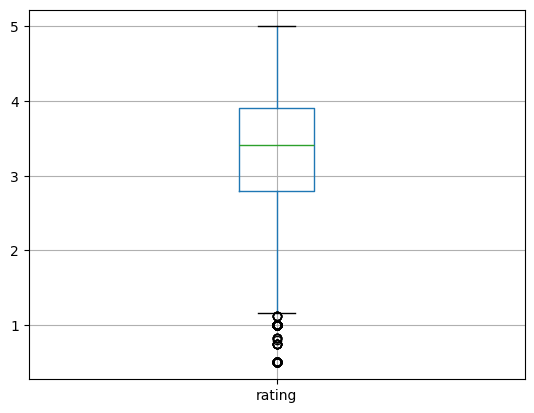

In [22]:
# Destaca outliers (bolinhas pretas) acerca de filmes com notas muito distintas dos outros)
ratings.boxplot(column="rating")

<Axes: >

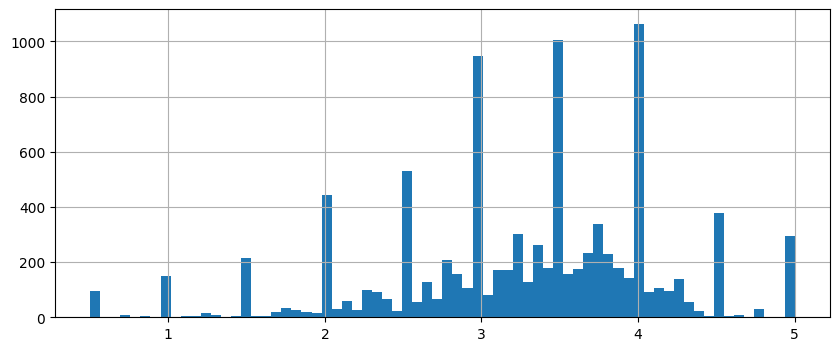

In [23]:
#Histograma da media de notas
plt.figure(figsize=(10,4))
ratings["rating"].hist(bins=70)